## Question 2

In [79]:
# Importation des librairies de base

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import gaussian_kde, probplot, skew, kurtosis, t as student_t, norm, chi2, ttest_rel
import wrds
import warnings
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings('ignore')

In [80]:
# Chargement des données depuis les fichiers CSV (même processus que Q1)

# 1. Charger les 17 Industry Portfolios
df_17_vw = pd.read_csv('17_Industry_Portfolios.csv', skiprows=11, nrows=1191)
df_17_vw.columns = df_17_vw.columns.str.strip()
df_17_vw = df_17_vw.rename(columns={df_17_vw.columns[0]: 'Date'})
df_17_vw['Date'] = df_17_vw['Date'].astype(str).str.strip()
df_17_vw = df_17_vw[df_17_vw['Date'].str.len() == 6]
df_17_vw = df_17_vw[(df_17_vw['Date'] >= '198001') & (df_17_vw['Date'] <= '202112')].copy()
for col in df_17_vw.columns[1:]:
    df_17_vw[col] = pd.to_numeric(df_17_vw[col], errors='coerce')

# 2. Charger les 5 facteurs Fama-French
df_FF5 = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows=3)
df_FF5.columns = df_FF5.columns.str.strip()
df_FF5 = df_FF5.rename(columns={df_FF5.columns[0]: 'Date'})
df_FF5['Date'] = df_FF5['Date'].astype(str).str.strip()
df_FF5 = df_FF5[df_FF5['Date'].str.len() == 6]
df_FF5 = df_FF5[(df_FF5['Date'] >= '198001') & (df_FF5['Date'] <= '202112')].copy()
for col in df_FF5.columns[1:]:
    df_FF5[col] = pd.to_numeric(df_FF5[col], errors='coerce')

# 3. Charger le facteur Momentum
df_Mom = pd.read_csv('F-F_Momentum_Factor.csv', skiprows=13)
df_Mom.columns = df_Mom.columns.str.strip()
df_Mom = df_Mom.rename(columns={df_Mom.columns[0]: 'Date'})
df_Mom['Date'] = df_Mom['Date'].astype(str).str.strip()
df_Mom = df_Mom[df_Mom['Date'].str.len() == 6]
df_Mom = df_Mom[(df_Mom['Date'] >= '198001') & (df_Mom['Date'] <= '202112')].copy()
for col in df_Mom.columns[1:]:
    df_Mom[col] = pd.to_numeric(df_Mom[col], errors='coerce')

# 4. Fusionner les datasets
df_6factors = pd.merge(df_FF5, df_Mom, on='Date', how='inner')
df_final = pd.merge(df_6factors, df_17_vw, on='Date', how='inner')

# 5. Créer les rendements excédentaires pour tous les secteurs
facteur_cols = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'Mom']
secteur_cols = [col for col in df_final.columns if col not in ['Date'] + facteur_cols]

# Créer le DataFrame final avec rendements excédentaires
cols_to_keep = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom', 'RF']
df_final_excess = df_final[cols_to_keep].copy()

for secteur in secteur_cols:
    df_final_excess[secteur] = df_final[secteur] - df_final['RF']

print(f"Données chargées : {df_final_excess.shape[0]} observations × {df_final_excess.shape[1]} colonnes")
print(f"Période : {df_final_excess['Date'].iloc[0]} à {df_final_excess['Date'].iloc[-1]}")

df_final_excess

Données chargées : 504 observations × 25 colonnes
Période : 198001 à 202112


,Date,Mkt-RF,SMB,HML,RMW,CMA,Mom,RF,Food,Mines,...,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
0,198001,5.50,1.88,1.85,-1.84,1.89,7.45,0.80,3.06,13.29,...,7.81,16.78,6.42,6.94,9.96,15.07,0.75,-0.63,1.31,3.10
1,198002,-1.23,-1.62,0.59,-0.95,2.92,7.89,0.89,-6.18,2.89,...,-3.01,-0.60,-1.91,-4.74,-7.42,-7.37,-4.31,-6.26,-5.91,-2.26
2,198003,-12.89,-6.97,-0.96,1.82,-1.05,-9.58,1.21,-10.24,-22.35,...,-16.08,-19.70,-17.92,-13.98,-10.77,-14.15,-7.81,-9.26,-10.13,-11.02
3,198004,3.96,1.05,1.03,-2.18,0.34,-0.48,1.26,5.79,1.10,...,2.77,1.04,2.69,-1.16,-4.15,-1.88,10.78,3.50,5.62,5.26
4,198005,5.26,2.00,0.38,0.43,-0.63,-1.18,0.81,7.16,9.18,...,8.06,4.39,4.89,4.07,2.32,5.06,3.79,9.45,7.06,5.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,202108,2.95,-0.66,-0.23,-0.26,-1.72,2.63,0.00,-0.41,-2.59,...,1.82,3.51,5.29,3.52,1.98,-0.67,3.23,3.02,2.86,3.93
500,202109,-4.40,1.12,5.12,-1.92,2.00,1.39,0.00,-3.39,-8.11,...,-3.71,-10.64,-5.68,-5.72,4.04,-2.11,-4.87,-5.43,-1.54,-5.74
501,202110,6.63,-2.70,-0.53,1.71,-1.54,3.32,0.00,3.42,8.68,...,11.42,10.14,3.71,7.57,30.82,6.06,5.11,3.77,7.07,5.51
502,202111,-1.58,-1.70,-0.37,7.19,1.70,0.96,0.00,-2.92,-0.18,...,5.31,-6.28,0.25,6.76,2.70,-5.46,-1.97,1.16,-5.68,-2.84


In [81]:
# Préparation des données pour la Question 2
# Choix du secteur : Finan (Services financiers)

secteur_choisi = 'Finan'  

# Variable dépendante : rendement excédentaire du secteur
y = df_final_excess[secteur_choisi].values

# Régresseurs : les 6 facteurs de Fama-French
facteurs = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom']
X = df_final_excess[facteurs].values

# Ajouter une constante pour la régression
X_with_const = sm.add_constant(X)

print(f"\nSecteur choisi : {secteur_choisi} (Services financiers)")
print(f"Nombre d'observations : {len(y)}")
print(f"Nombre de régresseurs : {len(facteurs)} facteurs + constante = {X_with_const.shape[1]}")

print(f"\n{'Statistiques descriptives - Variable dépendante:':<60}")
print(f"  Moyenne : {np.mean(y):.4f}%")
print(f"  Écart-type : {np.std(y):.4f}%")
print(f"  Minimum : {np.min(y):.4f}%")
print(f"  Maximum : {np.max(y):.4f}%")
print(f"  Asymétrie (skewness) : {skew(y):.4f}")
print(f"  Aplatissement (kurtosis) : {kurtosis(y):.4f}")


Secteur choisi : Finan (Services financiers)
Nombre d'observations : 504
Nombre de régresseurs : 6 facteurs + constante = 7

Statistiques descriptives - Variable dépendante:            
  Moyenne : 0.7948%
  Écart-type : 5.4985%
  Minimum : -22.4000%
  Maximum : 17.1200%
  Asymétrie (skewness) : -0.6141
  Aplatissement (kurtosis) : 2.2063


In [82]:
# Créer le DataFrame dans le format requis pour la Question 2

# Créer le DataFrame organisé
df_q2 = pd.DataFrame()

# Première colonne : Variable dépendante (rendement excédentaire Finan)
df_q2[f'{secteur_choisi}_excess'] = df_final_excess[secteur_choisi]

# Colonnes suivantes : Régresseurs (les 6 facteurs)
for facteur in facteurs:
    df_q2[facteur] = df_final_excess[facteur]

print(df_q2.head(10))

print(f"\nStatistiques descriptives :")
print(df_q2.describe().round(3))

# Extraire les données pour la régression
y = df_q2.iloc[:, 0].values  
X = df_q2.iloc[:, 1:].values  
X_with_const = sm.add_constant(X) 


   Finan_excess  Mkt-RF   SMB   HML   RMW   CMA   Mom
0          1.31    5.50  1.88  1.85 -1.84  1.89  7.45
1         -5.91   -1.23 -1.62  0.59 -0.95  2.92  7.89
2        -10.13  -12.89 -6.97 -0.96  1.82 -1.05 -9.58
3          5.62    3.96  1.05  1.03 -2.18  0.34 -0.48
4          7.06    5.26  2.00  0.38  0.43 -0.63 -1.18
5          4.22    2.97  1.46 -0.80 -0.20 -0.81  1.58
6          2.67    6.51  3.74 -6.29  4.06 -2.44  0.29
7          1.20    1.75  4.23 -2.46  2.05 -0.73  3.06
8          1.81    2.19  0.63 -4.61  1.90 -2.86  5.43
9         -0.85    1.04  2.21 -2.93  1.77 -1.43  7.13

Statistiques descriptives :
       Finan_excess   Mkt-RF      SMB      HML      RMW      CMA      Mom
count       504.000  504.000  504.000  504.000  504.000  504.000  504.000
mean          0.795    0.743    0.095    0.203    0.374    0.252    0.524
std           5.504    4.476    2.896    3.029    2.404    1.972    4.479
min         -22.400  -23.190  -15.540  -13.830  -18.950   -6.410  -34.340
25%    

In [83]:
df_q2

,Finan_excess,Mkt-RF,SMB,HML,RMW,CMA,Mom
0,1.31,5.50,1.88,1.85,-1.84,1.89,7.45
1,-5.91,-1.23,-1.62,0.59,-0.95,2.92,7.89
2,-10.13,-12.89,-6.97,-0.96,1.82,-1.05,-9.58
3,5.62,3.96,1.05,1.03,-2.18,0.34,-0.48
4,7.06,5.26,2.00,0.38,0.43,-0.63,-1.18
...,...,...,...,...,...,...,...
499,2.86,2.95,-0.66,-0.23,-0.26,-1.72,2.63
500,-1.54,-4.40,1.12,5.12,-1.92,2.00,1.39
501,7.07,6.63,-2.70,-0.53,1.71,-1.54,3.32
502,-5.68,-1.58,-1.70,-0.37,7.19,1.70,0.96


## Question 2(a)

In [84]:
def loglik_t_regression(df, dof):
    
    # Vérification des paramètres
    if dof <= 0:
        raise ValueError(f"dof n'est pas > 0, reçu : {dof}")
    
    # Extraire variable dépendante et régresseurs
    y = df.iloc[:, 0].values  
    X = df.iloc[:, 1:].values  
    
    # Ajouter une constante 
    X_with_const = sm.add_constant(X)
    
    # Ajuster le modèle de régression MCO
    model = sm.OLS(y, X_with_const)
    results = model.fit()
    
    # Extraire les résidus
    residuals = results.resid
    n = len(residuals)
    
    # Calculer l'écart-type des résidus (estimateur MLE)
    sigma_hat = np.sqrt(np.sum(residuals**2) / n)
    
    # Standardiser les résidus
    standardized_residuals = residuals / sigma_hat
    
    # Calculer la log-vraisemblance avec distribution Student-t
    
    # Terme 1: Somme des log-densités Student-t des résidus standardisés
    log_dens_sum = np.sum(student_t.logpdf(standardized_residuals, df=dof))
    
    # Terme 2: Correction pour l'échelle sigma
    log_sigma_term = -n * np.log(sigma_hat)
    
    # Log-vraisemblance totale
    log_likelihood = log_dens_sum + log_sigma_term
    
    return log_likelihood

# Tester avec différents degrés de liberté
test_dofs = [3, 5, 10, 30, 100]

print(f"\nDataFrame : {df_q2.shape[0]} observations, {df_q2.shape[1]} colonnes")
print(f"Variable dépendante : {df_q2.columns[0]}")
print(f"Régresseurs : {', '.join(df_q2.columns[1:])}")

print(f"\n{'Degrés de liberté':<25} {'Log-vraisemblance':<25}")

for dof in test_dofs:
    ll = loglik_t_regression(df_q2, dof)
    print(f"{dof:<25} {ll:<25.4f}")


DataFrame : 504 observations, 7 colonnes
Variable dépendante : Finan_excess
Régresseurs : Mkt-RF, SMB, HML, RMW, CMA, Mom

Degrés de liberté         Log-vraisemblance        
3                         -1093.4858               
5                         -1077.7645               
10                        -1069.5844               
30                        -1068.5346               
100                       -1070.0035               


## Question 2(b)

In [85]:
def likelihood_ratio_test(df, dof, alpha=0.05):
    
    # ÉTAPE 1: Calculer la log-vraisemblance du MODÈLE COMPLET
    loglik_full = loglik_t_regression(df, dof)
    
    print(f"\n{'MODÈLE COMPLET (H1)'}")
    print(f"Régresseurs : {', '.join(df.columns[1:])}")
    print(f"Nombre de paramètres : {len(df.columns)} (6 facteurs + constante)")
    print(f"Log-vraisemblance : {loglik_full:.4f}")
    
    # ÉTAPE 2: Calculer la log-vraisemblance du MODÈLE RESTREINT
    df_restricted = df.iloc[:, [0]].copy() 
    
    loglik_restricted = loglik_t_regression(df_restricted, dof)
    
    print(f"\n{'MODÈLE RESTREINT (H₀)'}")
    print(f"Régresseurs : Constante seule")
    print(f"Nombre de paramètres β : 1 (constante uniquement)")
    print(f"Log-vraisemblance : {loglik_restricted:.4f}")
    
    # ÉTAPE 3: Calculer la statistique du test LR
    LR_stat = 2 * (loglik_full - loglik_restricted)
    
    # ÉTAPE 4: Degrés de liberté = nombre de restrictions
    df_test = len(df.columns) - 1
    
    # ÉTAPE 5: Calculer la p-value sous distribution X2
    p_value = 1 - chi2.cdf(LR_stat, df=df_test)
    
    # ÉTAPE 6: Valeur critique
    critical_value = chi2.ppf(1 - alpha, df=df_test)
    
    # ÉTAPE 7: Décision du test
    reject_H0 = p_value < alpha
    
    print(f"\n{'STATISTIQUE DU TEST'}")
    print(f"LR = {LR_stat:.4f}")
    
    print(f"\n{'DISTRIBUTION SOUS H₀'}")
    print(f"Sous H₀, LR ({df_test})")
    print(f"Degrés de liberté : {df_test}")
    
    print(f"\n{'RÉSULTATS DU TEST'}")
    print(f"Niveau de significativité : {alpha}")
    print(f"Valeur critique ({df_test}, {alpha}) : {critical_value:.4f}")
    print(f"Statistique LR : {LR_stat:.4f}")
    print(f"Valeur p : {p_value:.6f}")
    
    if p_value < 0.0001:
        p_display = "< 0.0001"
    else:
        p_display = f"= {p_value:.4f}"
    
    # Retourner les résultats
    return {
        'LR_stat': LR_stat,
        'df_test': df_test,
        'p_value': p_value,
        'critical_value': critical_value,
        'reject_H0': reject_H0,
        'loglik_full': loglik_full,
        'loglik_restricted': loglik_restricted,
        'alpha': alpha
    }


# Test de la fonction avec le degré de liberté 15
optimal_dof = 15

results_lr = likelihood_ratio_test(df_q2, dof=optimal_dof, alpha=0.05)


MODÈLE COMPLET (H1)
Régresseurs : Mkt-RF, SMB, HML, RMW, CMA, Mom
Nombre de paramètres : 7 (6 facteurs + constante)
Log-vraisemblance : -1068.3556

MODÈLE RESTREINT (H₀)
Régresseurs : Constante seule
Nombre de paramètres β : 1 (constante uniquement)
Log-vraisemblance : -1566.3125

STATISTIQUE DU TEST
LR = 995.9138

DISTRIBUTION SOUS H₀
Sous H₀, LR (6)
Degrés de liberté : 6

RÉSULTATS DU TEST
Niveau de significativité : 0.05
Valeur critique (6, 0.05) : 12.5916
Statistique LR : 995.9138
Valeur p : 0.000000


## Question 2(c)

In [86]:
# ÉTAPE 1: Définir la grille de valeurs pour les degrés de liberté
j_values = np.arange(0, 51) 
dof_grid = np.exp(j_values / 12) 

# ÉTAPE 2: Calculer la log-vraisemblance pour chaque valeur de ν

loglik_profile = []

for i, dof in enumerate(dof_grid):
    ll = loglik_t_regression(df_q2, dof)
    loglik_profile.append(ll)
    
    if (i + 1) % 10 == 0 or i == 0 or i == len(dof_grid) - 1:
        print(f"  [{i+1:2d}/{len(dof_grid)}] ν = {dof:7.4f} → LogL = {ll:.4f}")

loglik_profile = np.array(loglik_profile)

# ÉTAPE 3: Identifier l'EMV (Maximum de Vraisemblance)
max_idx = np.argmax(loglik_profile)
dof_mle = dof_grid[max_idx]
loglik_mle = loglik_profile[max_idx]

print(f"EMV pour dof : {dof_mle:.4f}")
print(f"Log-vraisemblance maximale : {loglik_mle:.4f}")

# Créer un DataFrame avec les résultats
df_profile = pd.DataFrame({
    'j': j_values,
    'ν (dof)': dof_grid,
    'Log-vraisemblance': loglik_profile
})

  [ 1/51] ν =  1.0000 → LogL = -1184.0708
  [10/51] ν =  2.1170 → LogL = -1112.0558
  [20/51] ν =  4.8712 → LogL = -1078.3143
  [30/51] ν = 11.2084 → LogL = -1069.0688
  [40/51] ν = 25.7903 → LogL = -1068.3772
  [50/51] ν = 59.3430 → LogL = -1069.4179
  [51/51] ν = 64.5001 → LogL = -1069.5216
EMV pour dof : 18.4796
Log-vraisemblance maximale : -1068.2201


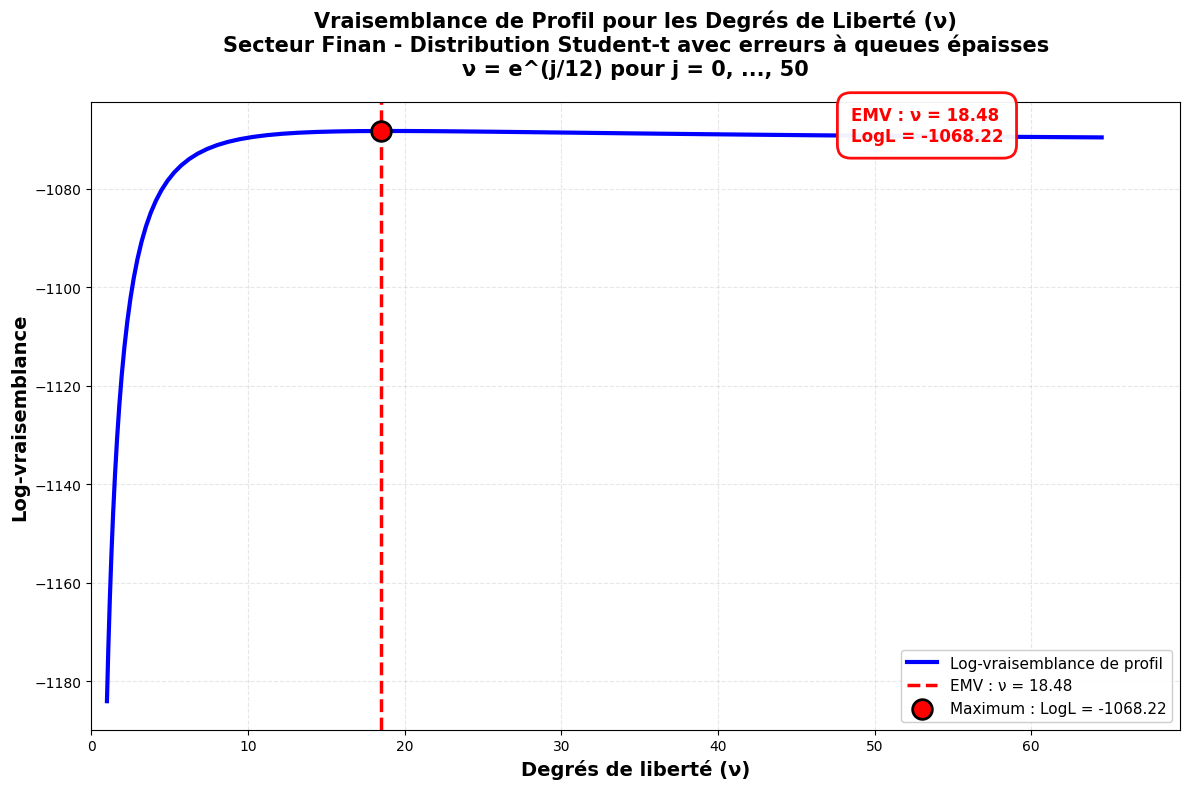

In [87]:
# GRAPHIQUE DE LA VRAISEMBLANCE DE PROFIL

plt.figure(figsize=(12, 8))

# Tracer la vraisemblance de profil
plt.plot(dof_grid, loglik_profile, 'b-', linewidth=3, label='Log-vraisemblance de profil')

# Marquer le maximum (EMV)
plt.axvline(dof_mle, color='red', linewidth=2.5, linestyle='--', 
            label=f'EMV : ν = {dof_mle:.2f}')
plt.scatter([dof_mle], [loglik_mle], color='red', s=200, zorder=5, 
            marker='o', edgecolors='black', linewidths=2, 
            label=f'Maximum : LogL = {loglik_mle:.2f}')

# Annotation
plt.annotate(f'EMV : ν = {dof_mle:.2f}\nLogL = {loglik_mle:.2f}', 
             xy=(dof_mle, loglik_mle), 
             xytext=(dof_mle + 30, loglik_mle - 2),
             fontsize=12, fontweight='bold', color='red',
             bbox=dict(boxstyle='round,pad=0.8', facecolor='white', alpha=0.95, edgecolor='red', linewidth=2),)

# Labels et titre
plt.xlabel('Degrés de liberté (ν)', fontsize=14, fontweight='bold')
plt.ylabel('Log-vraisemblance', fontsize=14, fontweight='bold')
plt.title(f'Vraisemblance de Profil pour les Degrés de Liberté (ν)\n' + 
          f'Secteur {secteur_choisi} - Distribution Student-t avec erreurs à queues épaisses\n' +
          f'ν = e^(j/12) pour j = 0, ..., 50', 
          fontsize=15, fontweight='bold', pad=20)

plt.legend(fontsize=11, loc='lower right', framealpha=0.95)
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
plt.xlim(0, dof_grid[-1] + 5)

plt.tight_layout()
plt.show()